In [498]:
import yaml
from mirage.src.mirage.engines.base import EngineV1
from mirage.src.mirage.processes import ProcessV1
from mirage.src.mirage.frameworks.epidemics import gpe
from mirage.configs.simulations.epidemics.epidemic_constants import *
import pprint
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

In [499]:
def truncated_sigmoid(x, min_val, max_val):
    sigmoid_x = expit(x)
    scaled_sigmoid_x = min_val + (sigmoid_x * (max_val - min_val))
    return scaled_sigmoid_x

In [500]:
file_path = "D:/IIT MANDI/KBG Coordinator/MIRAZ/Epidemic_2/NEW_ENGINE/epidemic_engine/mirage/configs/simulations/epidemics/countries/india.yaml"
with open(file_path, "r") as file:
    ind_config = yaml.load(file, Loader=yaml.FullLoader)
print(ind_config)

{'name': 'India', 'gdp': 2875140000, 'health_resource_stockpile': 50000.0, 'sanitation_equipment_stockpile': 50000.0, 'human_welfare_resource': 10000.0, 'happiness_index': 1.0, 'procedure_resistance': 0.6, 'cleanliness_index': 0.7, 'disease_research_center': 0, 'vaccine_research_center': 0, 'vaccines_stock': [{'name': 'ABC', 'quantity': 20, 'gdp_cost_per_step': 1000, 'effectiveness': 0.4}, {'name': 'ACB', 'quantity': 30, 'gdp_cost_per_step': 1000, 'effectiveness': 0.22}, {'name': 'BAC', 'quantity': 10, 'gdp_cost_per_step': 1000, 'effectiveness': 0.95}, {'name': 'BCA', 'quantity': 12, 'gdp_cost_per_step': 1000, 'effectiveness': -0.2}, {'name': 'CAB', 'quantity': 23, 'gdp_cost_per_step': 1000, 'effectiveness': 0.5}, {'name': 'CBA', 'quantity': 10, 'gdp_cost_per_step': 1000, 'effectiveness': 0.1}], 'loci': [{'name': 'Maharashtra', 'B': 0.001, 'C': 1e-06, 'E': 0.01, 'A': 0.01, 'Ds': 0.01, 'Di': 0.01, 'Dr': 0.01, 'lat': 19.7515, 'lon': 75.7139, 'susceptible': 112374333, 'infected': 100000, 

In [501]:
ind = gpe.Country(**ind_config)

### **BIRTH Process**

In [502]:
class BirthProcess(ProcessV1):
    RANK = 0
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        alpha = 0.5,
        beta = 0.3,
        gamma = 0.2,
        max_birth_rate = 0.35,
        economic_prosperity_THRESH =0.5
    ):
        # super().__init__(id, entities, status)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.max_birth_rate = max_birth_rate
        self.economic_prosperity_THRESH = economic_prosperity_THRESH

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        birth_rates = {}
        for country in self.entities:

            economic_prosperity = self.entities[country].human_welfare_resource

            for i, locus in enumerate(self.entities[country].loci):

                living_population_contribution = (
                    self.alpha * (locus.susceptible)
                    + self.beta * (locus.recovered)
                    + self.gamma * (locus.infected)
                ) / max_living_population

                if (economic_prosperity < self.economic_prosperity_THRESH) and (
                    economic_prosperity > base_birth_rate
                ):
                    birth_rate = (
                        (
                            self.alpha * (locus.susceptible)
                            + self.beta * (locus.recovered)
                            + self.gamma * (locus.infected)
                        )
                        * economic_prosperity
                        / max_living_population
                    )
                    if locus.A + birth_rate <= self.max_birth_rate:
                        locus.A += birth_rate
                    else:
                        locus.A = self.max_birth_rate

                elif economic_prosperity >= self.economic_prosperity_THRESH:
                    economic_prosperity_use = living_population_contribution * (
                        1 - (min_human_welfare_resource / economic_prosperity)
                    )
                    birth_rate = (
                        (2 / (1 + np.exp(-economic_prosperity_use))) - 1
                    ) * self.max_birth_rate

                    if locus.A + birth_rate <= self.max_birth_rate:
                        self.entities[country].loci[i].A += birth_rate
                    else:
                        locus.A = self.max_birth_rate
                elif economic_prosperity <= base_birth_rate:
                    birth_rate = base_birth_rate
                    if locus.A + birth_rate <= max_birth_rate:
                        locus.A += birth_rate
                    else:
                        locus.A = max_birth_rate

        return {
            "MaskImplementationProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.A
            for locus in self.entities[country].loci
        }

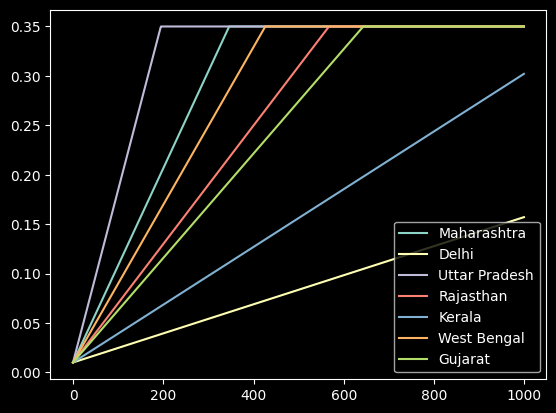

In [503]:
birth_p = BirthProcess(
    "birth_process",
    {"india": ind},
    "ALIVE",
)

k = []
for step in range(1000):
    k.append(birth_p.run(step))
    ind.sync()

data = {}
for i in k:
    for key, val in i.items():
        if key.split("_")[1] not in data:
            data[key.split("_")[1]] = []

        data[key.split("_")[1]].append(val)

for d in data:
    plt.plot(data[d], label=d)
plt.legend()
plt.show()

#### Every infectionRate Reducing Implementation can only reduce B bewteen the range of 5e-5 to 1e-6 every step

### **MASK IMPLEMENTATION**

In [504]:
class MaskImplementationProcess(ProcessV1):

    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        country: list,
        state: list,
        effect: list,
        health_resource_cost =5,
        sanitation_equipment_cost =5,
        trunk_min_value=1e-6,
        trunk_max_value=5e-5
    ):
        # super().__init__(id, entities, status)
        self.health_resource_cost = health_resource_cost 
        self.sanitation_equipment_cost = sanitation_equipment_cost
        self.state = state
        self.effect = effect
        self.country = country
        self.trunk_min_value = trunk_min_value
        self.trunk_max_value = trunk_max_value

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        #print("STEP: ", step)
        for i, country in enumerate(self.country):
            #print("COUNTRY: ", country, i)
            health_resource = self.entities[country].health_resource_stockpile
            sanitation_equipment = self.entities[country].sanitation_equipment_stockpile

            for locus in self.entities[country].loci:
                if locus.name == self.state[i]:
                    #print("Yes", locus.name, self.state, self.effect[i])
                    if (
                        health_resource >= self.health_resource_cost * self.effect[i] 
                        and sanitation_equipment >= self.sanitation_equipment_cost * self.effect[i]
                    ):
                        #print("ENOUNG RESOURCES", health_resource, sanitation_equipment, self.health_resource_cost * self.effect[i], self.sanitation_equipment_cost * self.effect[i])
                        if (
                            self.entities[country].health_resource_stockpile
                            - self.health_resource_cost * self.effect[i]
                            <= 0
                        ):
                            self.entities[country].health_resource_stockpile = 0
                        else:
                            self.entities[country].health_resource_stockpile -= self.health_resource_cost * self.effect[i]
                        if (
                            self.entities[country].sanitation_equipment_stockpile
                            - self.sanitation_equipment_cost * self.effect[i]
                            <= 0
                        ):
                            self.entities[country].sanitation_equipment_stockpile = 0
                        else:
                            self.entities[country].sanitation_equipment_stockpile -= self.sanitation_equipment_cost * self.effect[i]
                        
                        #print(locus.B, "LOCUS B")
                        if (locus.B - truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) / max_living_population, self.trunk_min_value, self.trunk_max_value) >= 1e-7):
                            #print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) / max_living_population, self.trunk_min_value, self.trunk_max_value), "TRUNCATED SIGMOID")
                            locus.B -= truncated_sigmoid(locus.B * self.effect[i] * (
                                locus.infected + locus.susceptible) / max_living_population, self.trunk_min_value, self.trunk_max_value)
                        else:
                            #print("Sigmoid missed")
                            #print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) /max_living_population, self.trunk_min_value, self.trunk_max_value), "TRUNCATED SIGMOID")
                            locus.B -= 0.02*locus.B*self.effect[i]
                    else:
                        #print("Insuff RES")
                        locus.B -= 0.000002*locus.B
                else:
                    pass

        return {
            "MaskImplementation"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

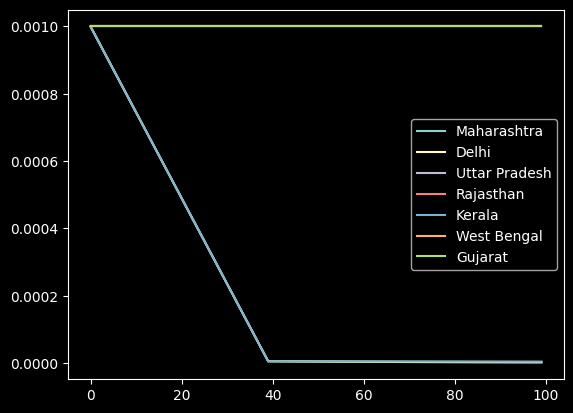

In [505]:
mask_implementaton_process = MaskImplementationProcess(
    "MaskImplementation",
    {"india": ind},
    "ALIVE",
    ["india", "india", "india"],
    ["Delhi", "Maharashtra", "Kerala"],
    [0.9, 0.4, 0.2]
)

k = []
for step in range(100):
    k.append(mask_implementaton_process.run(step))
    ind.sync()

data = {}
for i in k:
    for key, val in i.items():
        if key.split("_")[1] not in data:
            data[key.split("_")[1]] = []

        data[key.split("_")[1]].append(val)

for d in data:
    plt.plot(data[d], label=d)
plt.legend()
plt.show()

### **AID Kits**

In [506]:
ind = gpe.Country(**ind_config)

In [507]:
ind = gpe.Country(**ind_config)

In [508]:
# Make AidKitImplementationProcess class similar to the above processes structure
class AidKitImplementationProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        country: list,
        state: list,
        effect: list,
        health_resource_cost=20,
        trunk_min_value=1e-6,
        trunk_max_value=5e-5
    ):

        # super().__init__(id, entities, status)
        self.state = state
        self.health_resource_cost = health_resource_cost
        self.country = country
        self.state = state
        self.status = status
        self.effect = effect
        self.trunk_min_value = trunk_min_value
        self.trunk_max_value = trunk_max_value

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        # print("STEP: ", step)
        for i, country in enumerate(self.country):
            # print("COUNTRY: ", country, i)
            health_resource = self.entities[country].health_resource_stockpile

            for locus in self.entities[country].loci:
                if locus.name == self.state[i]:
                    # print("Yes", locus.name, self.state, self.effect[i])
                    if (
                        health_resource >= self.health_resource_cost *
                            self.effect[i]
                    ):
                        # print("ENOUNG RESOURCES", health_resource, sanitation_equipment, self.healt)
                        if (
                            self.entities[country].health_resource_stockpile
                            - self.health_resource_cost * self.effect[i]
                            <= 0
                        ):
                            self.entities[country].health_resource_stockpile = 0
                        else:
                            self.entities[country].health_resource_stockpile -= self.health_resource_cost * self.effect[i]


                        # print(locus.B, "LOCUS B")
                        if (locus.B - truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) / max_living_population, self.trunk_min_value, self.trunk_max_value) >= 1e-7):
                            # print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) / max_living_population, self.trunk_min_value, self.trunk_max_value), "TRUNCATED SIGMOID")
                            locus.B -= truncated_sigmoid(locus.B * self.effect[i] * (
                                locus.infected + locus.susceptible) / max_living_population, self.trunk_min_value, self.trunk_max_value)
                        else:
                            # print("Sigmoid missed")
                            # print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) /max_living_population, self.trunk_min_value, self.trunk_max_value), "TRUNCATED SIGMOID")
                            locus.B -= 0

                        # print(locus.name, locus.B, "LOCUS B")
                        # print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) /max_living_population, self.trunk_min_value, self.trunk_max_value), "TRUNCATED SIGMOID")

                    else:
                        # print("Insuff RES")
                        locus.B -= 0
                else:
                    pass
        return {
            "AidKitImplementationProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

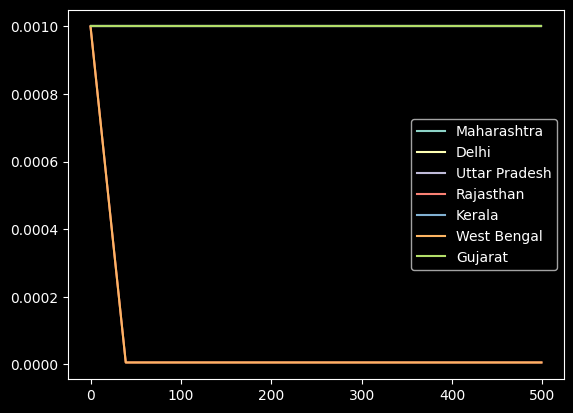

In [509]:
Aid_kit_process = AidKitImplementationProcess(
    "AidKitImplementationProcess",
    {"india": ind},
    "ALIVE",
    ["india", "india"],
    ["Rajasthan", "West Bengal"],
    [0.2, 0.9]
)

k = []
for i in range(500):
    k.append(Aid_kit_process.run(i))
    ind.sync()

data = {}
for i in k:
    for key, val in i.items():
        if key.split("_")[1] not in data:
            data[key.split("_")[1]] = []

        data[key.split("_")[1]].append(val)

for d in data:
    plt.plot(data[d], label=d)
plt.legend()
plt.show()

### **General Sanitation**

In [510]:
ind = gpe.Country(**ind_config)

In [511]:

class General_Sanitation_Implementation(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        country: list,
        state: list,
        effect: list,
        sanitation_resource_cost=100,
        trunk_min_value=1e-6,
        trunk_max_value=5e-5
    ):

        # super().__init__(id, entities, status)
        self.state = state
        self.sanitation_resource_cost = sanitation_resource_cost
        self.country = country
        self.state = state
        self.status = status
        self.effect = effect
        self.trunk_min_value = trunk_min_value
        self.trunk_max_value = trunk_max_value

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        # print("STEP: ", step)
        for i, country in enumerate(self.country):
            # print("COUNTRY: ", country, i)
            health_resource = self.entities[country].sanitation_equipment_stockpile

            for locus in self.entities[country].loci:
                if locus.name == self.state[i]:
                    # print("Yes", locus.name, self.state, self.effect[i])
                    if (
                        health_resource >= self.sanitation_resource_cost *
                            self.effect[i] * (locus.susceptible + locus.infected + locus.recovered) / (locus.area * max_living_population)
                    ):
                        # print("ENOUNG RESOURCES", health_resource, sanitation_equipment, self.healt)
                        if (
                            self.entities[country].health_resource_stockpile
                            - self.sanitation_resource_cost * self.effect[i] * (locus.susceptible + locus.infected + locus.recovered) / (locus.area * max_living_population)
                            <= 0
                        ):
                            self.entities[country].health_resource_stockpile = 0
                        else:
                            self.entities[country].health_resource_stockpile -= self.sanitation_resource_cost * self.effect[i] * (locus.susceptible + locus.infected + locus.recovered) / (locus.area * max_living_population)

                        # print(locus.B, "LOCUS B")
                        if (locus.B - truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible + locus.recovered) / max_living_population, self.trunk_min_value, self.trunk_max_value) >= 1e-7):
                            # print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) / max_living_population, self.trunk_min_value, self.trunk_max_value), "TRUNCATED SIGMOID")
                            locus.B -= truncated_sigmoid(locus.B * self.effect[i] * (
                                locus.infected + locus.susceptible + locus.recovered) / max_living_population, self.trunk_min_value, self.trunk_max_value)
                        else:
                            # print("Sigmoid missed")
                            # print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) /max_living_population, self.trunk_min_value, self.trunk_max_value), "TRUNCATED SIGMOID")
                            locus.B -= 0

                        # print(locus.name, locus.B, "LOCUS B")
                        # print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) /max_living_population, self.trunk_min_value, self.trunk_max_value), "TRUNCATED SIGMOID")

                    else:
                        # print("Insuff RES")
                        locus.B -= 0
                else:
                    pass
        return {
            "GeneralSanitationImplementation"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

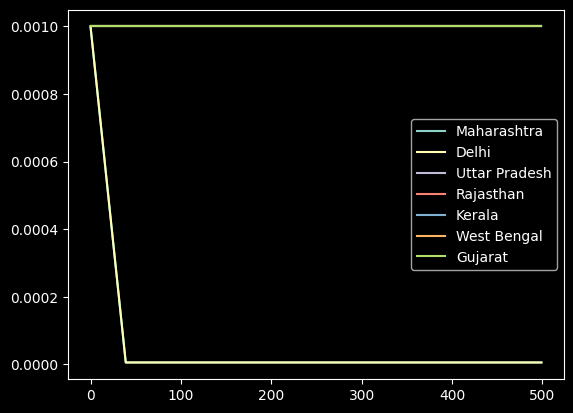

In [512]:
Gen_Sanitation_process = General_Sanitation_Implementation(
    "GeneralSanitationImplementation",
    {"india": ind},
    "ALIVE",
    ["india", "india"],
    ["Delhi", "Maharashtra"],
    [0.9, 0.9]
)

k = []
for i in range(500):
    k.append(Gen_Sanitation_process.run(i))
    ind.sync()

data = {}
for i in k:
    for key, val in i.items():
        if key.split("_")[1] not in data:
            data[key.split("_")[1]] = []

        data[key.split("_")[1]].append(val)

for d in data:
    plt.plot(data[d], label=d)
plt.legend()
plt.show()

### **Quarantine Facilities**

In [513]:
ind = gpe.Country(**ind_config)

In [514]:
class QuarantineFacilitiesQProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        country,
        state,
        num_centers,
        gdp_cost_per_center=500,
        health_resource_cost=20,
        sanitation_equipment_cost=20,
        trunk_min_value=1e-6,
        trunk_max_value=5e-5

    ):

        # super().__init__(id, entities, status)
        self.gdp_cost_per_center = gdp_cost_per_center
        self.health_resource_cost = health_resource_cost
        self.sanitation_equipment_cost = sanitation_equipment_cost
        self.num_centers = num_centers
        self.state = state
        self.country = country  
        self.trunk_min_value = trunk_min_value
        self.trunk_max_value = trunk_max_value

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        # print("STEP: ", step)
        for i, country in enumerate(self.country):
            # print("COUNTRY: ", country, i)
            health_resource = self.entities[country].health_resource_stockpile
            sanitation_equipment = self.entities[country].sanitation_equipment_stockpile
            gdp = self.entities[country].gdp

            for locus in self.entities[country].loci:
                if locus.name == self.state[i]:
                    # print("Yes", locus.name, self.state, self.effect[i])
                    if (
                        health_resource >= self.health_resource_cost * self.num_centers[i]
                        and sanitation_equipment >= self.sanitation_equipment_cost * self.num_centers[i]
                        and gdp >= self.gdp_cost_per_center * self.num_centers[i]
                    ):
                        # print("ENOUNG RESOURCES", health_resource, sanitation_equipment, self.healt)
                        if (
                            self.entities[country].health_resource_stockpile
                            - self.health_resource_cost * self.num_centers[i]
                            <= 0
                        ):
                            self.entities[country].health_resource_stockpile = 0
                        else:
                            self.entities[country].health_resource_stockpile -= self.health_resource_cost * self.num_centers[i]

                        if (
                            self.entities[country].sanitation_equipment_stockpile
                            - self.sanitation_equipment_cost * self.num_centers[i]
                            <= 0
                        ):
                            self.entities[country].sanitation_equipment_stockpile = 0
                        else:
                            self.entities[country].sanitation_equipment_stockpile -= self.sanitation_equipment_cost * self.num_centers[i]

                        if (
                            self.entities[country].gdp
                            - self.gdp_cost_per_center * self.num_centers[i]
                            <= 0
                        ):
                            self.entities[country].gdp = 0
                        else:
                            self.entities[country].gdp -= self.gdp_cost_per_center * self.num_centers[i]

                        # print(locus.B, "LOCUS B")
                        if (locus.B - truncated_sigmoid(locus.B * self.num_centers[i] * (locus.infected + locus.susceptible) / max_living_population, self.trunk_min_value, self.trunk_max_value) >= 1e-7):
                            # print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) / max_l
                            locus.B -= truncated_sigmoid(locus.B * self.num_centers[i] * (
                                locus.infected + locus.susceptible) / max_living_population, self.trunk_min_value, self.trunk_max_value)
                        else:
                            # print("Sigmoid missed")
                            # print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) /max_living_population, self.trunk_min_value, self.trunk_max_value)
                            locus.B -= 0

                        # print(locus.name, locus.B, "LOCUS B")
                        # print(truncated_sigmoid(locus.B * self.effect[i] * (locus.infected + locus.susceptible) /max_living_population, self.trunk_min_value, self.trunk_max_value)

                    else:
                        # print("Insuff RES")
                        locus.B -= 0

                else:
                    pass

        return {
            "QuarantineFacilitiesQProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }



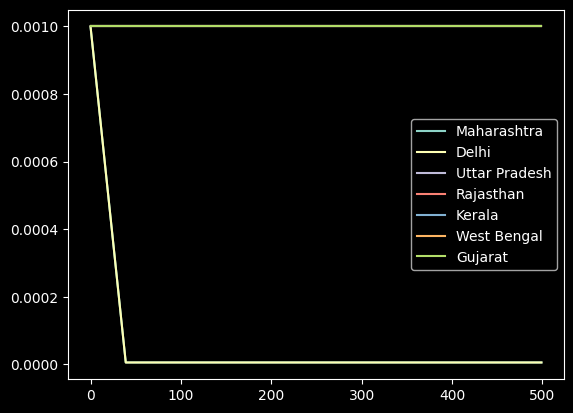

In [515]:
QuarantineFacilitiesQProcess = QuarantineFacilitiesQProcess(
    "QuarantineFacilitiesQProcess",
    {"india": ind},
    "ALIVE",
    ["india", "india"],
    ["Delhi", "Maharashtra"],
    [50,5]
)

k = []
for i in range(500):
    k.append(QuarantineFacilitiesQProcess.run(i))
    ind.sync()

data = {}
for i in k:
    for key, val in i.items():
        if key.split("_")[1] not in data:
            data[key.split("_")[1]] = []

        data[key.split("_")[1]].append(val)

for d in data:
    plt.plot(data[d], label=d)
plt.legend()
plt.show()


In [533]:
k

[{'ALIVE/AirPortEffectChangeProcess_Maharashtra_india': 0.3076500705181088,
  'ALIVE/AirPortEffectChangeProcess_Delhi_india': 0.18467037807043143,
  'ALIVE/AirPortEffectChangeProcess_Uttar Pradesh_india': 0.13317413478146867,
  'ALIVE/AirPortEffectChangeProcess_Rajasthan_india': 0.14051132124951463,
  'ALIVE/AirPortEffectChangeProcess_Kerala_india': 0.306347873657542,
  'ALIVE/AirPortEffectChangeProcess_West Bengal_india': 0.19733427578705703,
  'ALIVE/AirPortEffectChangeProcess_Gujarat_india': 0.2878113158158034},
 {'ALIVE/AirPortEffectChangeProcess_Maharashtra_india': 0.30930843604218905,
  'ALIVE/AirPortEffectChangeProcess_Delhi_india': 0.1855300660782305,
  'ALIVE/AirPortEffectChangeProcess_Uttar Pradesh_india': 0.13403382278926773,
  'ALIVE/AirPortEffectChangeProcess_Rajasthan_india': 0.1413710092573137,
  'ALIVE/AirPortEffectChangeProcess_Kerala_india': 0.3072075616653411,
  'ALIVE/AirPortEffectChangeProcess_West Bengal_india': 0.1989926413111373,
  'ALIVE/AirPortEffectChangeProc

### **Changing Effect size of Economic Zones**

PASSIVE: (Trickle add B (by Activity) and GDP trickle from Zones (by Activity))
<br>
ACTIVE: (Change Activity of Economic Zones)

In [516]:
ind = gpe.Country(**ind_config)

In [517]:
class EconomicZoneEffectChangeProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        change_country = [],
        economic_zone_names = [],
        effect = [],
        trunk_min_value=1e-5,
        trunk_max_value=5e-4,
        max_tier = 4,
        gdp_multiplier=5e-4 * 1e5

    ):

        # Give Country and economic zone name as list with same index corresponding to each others country (with same name as Initialized Entity) and economic zone name

        #super().__init__(id, entities, status)
        self.change_country = change_country
        self.economic_zone_names = economic_zone_names
        self.effect = effect
        self.status = status
        self.trunk_min_value = trunk_min_value
        self.trunk_max_value = trunk_max_value
        self.max_tier = max_tier
        self.gdp_multiplier = gdp_multiplier

    def while_dormant(self, step: int):
        pass

    def auto_run(self):
    # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
        for country in self.entities.keys():
            for locus in self.entities[country].loci:
                total_b_increase = 0
                total_gdp_increase = 0
                if locus.economic_zones != None:
                    for economicZone in locus.economic_zones:
                        # print(economicZone["name"], economicZone["b_val_increase"])
                        total_b_increase += truncated_sigmoid(
                            (self.max_tier - economicZone["zone_tier"]) * economicZone["effect"], self.trunk_min_value, self.trunk_max_value)
                        total_gdp_increase += total_b_increase * self.gdp_multiplier
                    # print(locus.name, total_b_increase, "name", "Increase")
                    if locus.B + total_b_increase < 1:
                        locus.B += total_b_increase
                    else:
                        locus.B -= 0.1*locus.B
                    
                    self.entities[country].gdp += total_gdp_increase


    def while_alive(self, step: int):
        if len(self.change_country) != len(self.economic_zone_names):
            raise ValueError(
                "Length of change country, economic_zone_name and effect should be same"
            )

        elif len(self.change_country) == 0:
            print("here")
            # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
            self.auto_run()

        elif len(self.change_country) > 0 and len(self.change_country) == len(
            self.economic_zone_names
        ):
            print("here")
            for i, country in enumerate(self.change_country):
                print(country, "country", self.economic_zone_names[i], "zone", self.effect[i], "effect" )
                for locus in self.entities[country].loci:
                    for economicZone in locus.economic_zones: 
                        print(economicZone["name"], "Current", self.economic_zone_names[i], "Wanted")
                        if economicZone["name"] == self.economic_zone_names[i]:
                            print("in")
                            print(economicZone["name"], locus.name)
                            economicZone["effect"] = self.effect[i]
            self.auto_run()


        return {
            "EconomicZoneEffectChangeProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

here
india country Kolkata SEZ zone 0.01 effect
Mumbai SEZ Current Kolkata SEZ Wanted
Pune IT Park Current Kolkata SEZ Wanted
Delhi SEZ Current Kolkata SEZ Wanted
Gurgaon Industrial Zone Current Kolkata SEZ Wanted
Noida SEZ Current Kolkata SEZ Wanted
Jaipur SEZ Current Kolkata SEZ Wanted
Cochin SEZ Current Kolkata SEZ Wanted
Kolkata SEZ Current Kolkata SEZ Wanted
in
Kolkata SEZ West Bengal
Durgapur Industrial Zone Current Kolkata SEZ Wanted
Ahmedabad SEZ Current Kolkata SEZ Wanted
Surat Diamond Park Current Kolkata SEZ Wanted
india country Surat Diamond Park zone 0.01 effect
Mumbai SEZ Current Surat Diamond Park Wanted
Pune IT Park Current Surat Diamond Park Wanted
Delhi SEZ Current Surat Diamond Park Wanted
Gurgaon Industrial Zone Current Surat Diamond Park Wanted
Noida SEZ Current Surat Diamond Park Wanted
Jaipur SEZ Current Surat Diamond Park Wanted
Cochin SEZ Current Surat Diamond Park Wanted
Kolkata SEZ Current Surat Diamond Park Wanted
Durgapur Industrial Zone Current Surat Diamo

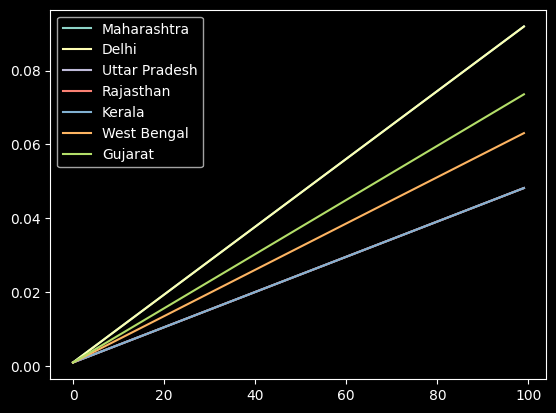

In [518]:
economic_zone_effect_change_process = EconomicZoneEffectChangeProcess(
    "EconomicZoneEffectChangeProcess",
    {"india": ind},
    "ALIVE",
    ["india", "india"],
    ["Kolkata SEZ", "Surat Diamond Park"],
    [0.01, 0.01]
)

k = []
for i in range(100):
    k.append(economic_zone_effect_change_process.run(i))
    ind.sync()

data = {}
for i in k:
    for key, val in i.items():
        if key.split("_")[1] not in data:
            data[key.split("_")[1]] = []

        data[key.split("_")[1]].append(val)

for d in data:
    plt.plot(data[d], label=d)
plt.legend()
plt.show()


### **Changing Effect size of Tourist Zones**

PASSIVE: (Trickle add B (by Activity) and GDP trickle from Zones (by Activity))
<br>
ACTIVE: (Change Activity of Tourist Zones)

In [519]:
class TouristZoneEffectChangeProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        change_country=[],
        tourist_zone_names=[],
        effect=[],
        trunk_min_value=1e-5,
        trunk_max_value=5e-4,
        max_tier=4,
        gdp_multiplier=5e-4 * 5e5

    ):
    # Give Country and economic zone name as list with same index corresponding to each others country (with same name as Initialized Entity) and economic zone name

        # super().__init__(id, entities, status)
        self.change_country = change_country
        self.tourist_zone_names = tourist_zone_names
        self.effect = effect
        self.status = status
        self.trunk_min_value = trunk_min_value
        self.trunk_max_value = trunk_max_value
        self.max_tier = max_tier
        self.gdp_multiplier = gdp_multiplier


    def while_dormant(self, step: int):
        pass

    def auto_run(self):
        # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
        for country in self.entities.keys():
            for locus in self.entities[country].loci:
                total_b_increase = 0
                total_gdp_increase = 0
                if locus.tourist_zones != None:
                    for touristZone in locus.tourist_zones:
                        # print(economicZone["name"], economicZone["b_val_increase"])
                        total_b_increase += truncated_sigmoid(
                            (self.max_tier - touristZone["zone_tier"]) * touristZone["effect"], self.trunk_min_value, self.trunk_max_value)
                        total_gdp_increase += total_b_increase * self.gdp_multiplier
                    # print(locus.name, total_b_increase, "name", "Increase")
                    if locus.B + total_b_increase < 1:
                        locus.B += total_b_increase
                    else:
                        locus.B -= 0.1*locus.B
                    
                    self.entities[country].gdp += total_gdp_increase

    def while_alive(self, step: int):
        if len(self.change_country) != len(self.tourist_zone_names):
            raise ValueError(
                "Length of change country, tourist_zone_name and effect should be same"
            )

        elif len(self.change_country) == 0:
            print("here")
            # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
            self.auto_run()

        elif len(self.change_country) > 0 and len(self.change_country) == len(
            self.tourist_zone_names
        ):
            print("here")
            for i, country in enumerate(self.change_country):
                print(country, "country",
                      self.tourist_zone_names[i], "zone", self.effect[i], "effect")
                for locus in self.entities[country].loci:
                    for touristZone in locus.tourist_zones:
                        print(touristZone["name"], "Current",
                              self.tourist_zone_names[i], "Wanted")
                        if touristZone["name"] == self.tourist_zone_names[i]:
                            print("in")
                            print(touristZone["name"], locus.name)
                            touristZone["effect"] = self.effect[i]
            self.auto_run()

        return {
            "TouristZoneEffectChangeProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

here
india country Gateway of India zone 0.01 effect
Gateway of India Current Gateway of India Wanted
in
Gateway of India Maharashtra
Elephanta Caves Current Gateway of India Wanted
Qutub Minar Current Gateway of India Wanted
Red Fort Current Gateway of India Wanted
Taj Mahal Current Gateway of India Wanted
Varanasi Spiritual Hub Current Gateway of India Wanted
Jaipur Historical Sites Current Gateway of India Wanted
Udaipur Historical Sites Current Gateway of India Wanted
Kerala Backwaters Current Gateway of India Wanted
Munnar Tea Estates Current Gateway of India Wanted
Victoria Memorial Current Gateway of India Wanted
Sabarmati Ashram Current Gateway of India Wanted
india country Elephanta Caves zone 0.01 effect
Gateway of India Current Elephanta Caves Wanted
Elephanta Caves Current Elephanta Caves Wanted
in
Elephanta Caves Maharashtra
Qutub Minar Current Elephanta Caves Wanted
Red Fort Current Elephanta Caves Wanted
Taj Mahal Current Elephanta Caves Wanted
Varanasi Spiritual Hub Cur

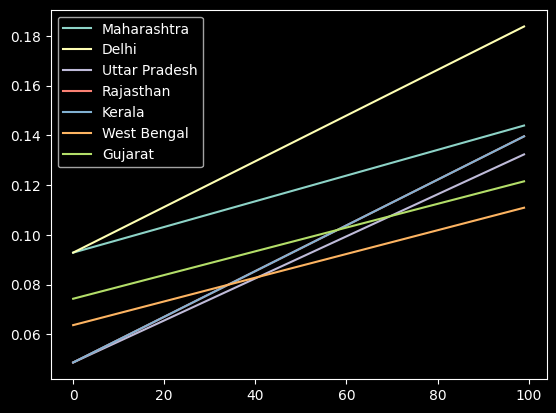

In [520]:
tourist_zone_effect_change_process = TouristZoneEffectChangeProcess(
    "TouristZoneEffectChangeProcess",
    {"india": ind},
    "ALIVE",
    ["india", "india"],
    ["Gateway of India", "Elephanta Caves"],
    [0.01, 0.01]
)

k = []
for i in range(100):
    k.append(tourist_zone_effect_change_process.run(i))
    ind.sync()

data = {}
for i in k:
    for key, val in i.items():
        if key.split("_")[1] not in data:
            data[key.split("_")[1]] = []

        data[key.split("_")[1]].append(val)

for d in data:
    plt.plot(data[d], label=d)
plt.legend()
plt.show()

In [521]:
class PortEffectChangeProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        change_country=[],
        port_names=[],
        effect=[],
        trunk_min_value=5e-5,
        trunk_max_value=9e-4,
        max_tier=4,
        gdp_multiplier=9e-4 * 1e6

    ):
        # Give Country and economic zone name as list with same index corresponding to each others country (with same name as Initialized Entity) and economic zone name

        # super().__init__(id, entities, status)
        self.change_country = change_country
        self.port_names = port_names
        self.effect = effect
        self.status = status
        self.trunk_min_value = trunk_min_value
        self.trunk_max_value = trunk_max_value
        self.max_tier = max_tier
        self.gdp_multiplier = gdp_multiplier

    def while_dormant(self, step: int):
        pass

    def auto_run(self):
        # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
        for country in self.entities.keys():
            for locus in self.entities[country].loci:
                total_b_increase = 0
                total_gdp_increase = 0
                if locus.ports != None:
                    for portZones in locus.ports:
                        # print(economicZone["name"], economicZone["b_val_increase"])
                        total_b_increase += truncated_sigmoid(
                            (self.max_tier - portZones["zone_tier"]) * portZones["effect"], self.trunk_min_value, self.trunk_max_value)
                        total_gdp_increase += total_b_increase * self.gdp_multiplier
                    # print(locus.name, total_b_increase, "name", "Increase")
                    if locus.B + total_b_increase < 1:
                        locus.B += total_b_increase
                    else:
                        locus.B -= 0.1*locus.B

                    self.entities[country].gdp += total_gdp_increase

    def while_alive(self, step: int):
        if len(self.change_country) != len(self.port_names):
            raise ValueError(
                "Length of change country, tourist_zone_name and effect should be same"
            )

        elif len(self.change_country) == 0:
            print("here")
            # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
            self.auto_run()

        elif len(self.change_country) > 0 and len(self.change_country) == len(
            self.port_names
        ):
            print("here")
            for i, country in enumerate(self.change_country):
                print(country, "country",
                      self.port_names[i], "zone", self.effect[i], "effect")
                for locus in self.entities[country].loci:
                    if locus.ports != None:
                        for portZones in locus.ports:
                            print(portZones["name"], "Current",
                                self.port_names[i], "Wanted")
                            if portZones["name"] == self.port_names[i]:
                                print("in")
                                print(portZones["name"], locus.name)
                                portZones["effect"] = self.effect[i]
            self.auto_run()

        return {
            "PortEffectChangeProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

here
india country Mumbai Port zone 0.01 effect
Mumbai Port Current Mumbai Port Wanted
in
Mumbai Port Maharashtra
Jawaharlal Nehru Port Current Mumbai Port Wanted
Goa Port Current Mumbai Port Wanted
Cochin Port Current Mumbai Port Wanted
Vizhinjam Port Current Mumbai Port Wanted
Kolkata Port Current Mumbai Port Wanted
Kandla Port Current Mumbai Port Wanted
Mundra Port Current Mumbai Port Wanted
india country Jawaharlal Nehru Port zone 0.01 effect
Mumbai Port Current Jawaharlal Nehru Port Wanted
Jawaharlal Nehru Port Current Jawaharlal Nehru Port Wanted
in
Jawaharlal Nehru Port Maharashtra
Goa Port Current Jawaharlal Nehru Port Wanted
Cochin Port Current Jawaharlal Nehru Port Wanted
Vizhinjam Port Current Jawaharlal Nehru Port Wanted
Kolkata Port Current Jawaharlal Nehru Port Wanted
Kandla Port Current Jawaharlal Nehru Port Wanted
Mundra Port Current Jawaharlal Nehru Port Wanted
here
india country Mumbai Port zone 0.01 effect
Mumbai Port Current Mumbai Port Wanted
in
Mumbai Port Maharas

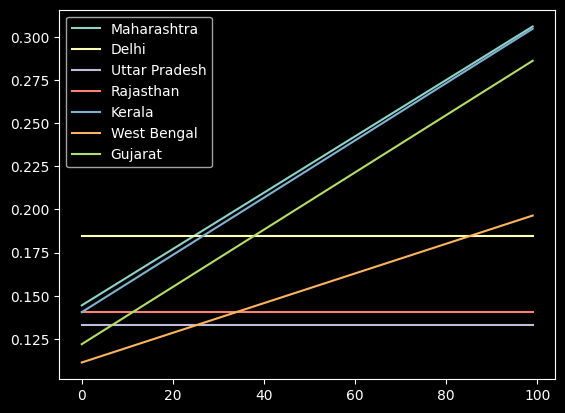

In [522]:
port_zone_effect_change_process = PortEffectChangeProcess(
    "PortEffectChangeProcess",
    {"india": ind},
    "ALIVE",
    ["india", "india"],
    ["Mumbai Port", "Jawaharlal Nehru Port"],
    [0.01, 0.01]
)

k = []
for i in range(100):
    k.append(port_zone_effect_change_process.run(i))
    ind.sync()

data = {}
for i in k:
    for key, val in i.items():
        if key.split("_")[1] not in data:
            data[key.split("_")[1]] = []

        data[key.split("_")[1]].append(val)

for d in data:
    plt.plot(data[d], label=d)
plt.legend()
plt.show()

In [523]:
class AirPortEffectChangeProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        change_country=[],
        air_port_names=[],
        effect=[],
        trunk_min_value=5e-5,
        trunk_max_value=9e-4,
        max_tier=4,
        gdp_multiplier=9e-4 * 1e6

    ):
        # Give Country and economic zone name as list with same index corresponding to each others country (with same name as Initialized Entity) and economic zone name

        # super().__init__(id, entities, status)
        self.change_country = change_country
        self.air_port_names = air_port_names
        self.effect = effect
        self.status = status
        self.trunk_min_value = trunk_min_value
        self.trunk_max_value = trunk_max_value
        self.max_tier = max_tier
        self.gdp_multiplier = gdp_multiplier

    def while_dormant(self, step: int):
        pass

    def auto_run(self):
        # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
        for country in self.entities.keys():
            for locus in self.entities[country].loci:
                total_b_increase = 0
                total_gdp_increase = 0
                if locus.airports != None:
                    for portZones in locus.airports:
                        # print(economicZone["name"], economicZone["b_val_increase"])
                        total_b_increase += truncated_sigmoid(
                            (self.max_tier - portZones["zone_tier"]) * portZones["effect"], self.trunk_min_value, self.trunk_max_value)
                        total_gdp_increase += total_b_increase * self.gdp_multiplier
                    # print(locus.name, total_b_increase, "name", "Increase")
                    if locus.B + total_b_increase < 1:
                        locus.B += total_b_increase
                    else:
                        locus.B -= 0.1*locus.B

                    self.entities[country].gdp += total_gdp_increase

    def while_alive(self, step: int):
        if len(self.change_country) != len(self.air_port_names):
            raise ValueError(
                "Length of change country, tourist_zone_name and effect should be same"
            )

        elif len(self.change_country) == 0:
            print("here")
            # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
            self.auto_run()

        elif len(self.change_country) > 0 and len(self.change_country) == len(
            self.air_port_names
        ):
            print("here")
            for i, country in enumerate(self.change_country):
                print(country, "country",
                      self.air_port_names[i], "zone", self.effect[i], "effect")
                for locus in self.entities[country].loci:
                    if locus.airports != None:
                        for portZones in locus.airports:
                            print(portZones["name"], "Current",
                                  self.air_port_names[i], "Wanted")
                            if portZones["name"] == self.air_port_names[i]:
                                print("in")
                                print(portZones["name"], locus.name)
                                portZones["effect"] = self.effect[i]
            self.auto_run()

        return {
            "AirPortEffectChangeProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

here
india country Pune International Airport zone 1 effect
Chhatrapati Shivaji Maharaj International Airport Current Pune International Airport Wanted
Pune International Airport Current Pune International Airport Wanted
in
Pune International Airport Maharashtra
Indira Gandhi International Airport Current Pune International Airport Wanted
Chaudhary Charan Singh International Airport Current Pune International Airport Wanted
Jaipur International Airport Current Pune International Airport Wanted
Cochin International Airport Current Pune International Airport Wanted
Netaji Subhas Chandra Bose International Airport Current Pune International Airport Wanted
Bagdogra Airport Current Pune International Airport Wanted
Sardar Vallabhbhai Patel International Airport Current Pune International Airport Wanted
india country Indira Gandhi International Airport zone 1 effect
Chhatrapati Shivaji Maharaj International Airport Current Indira Gandhi International Airport Wanted
Pune International Airport

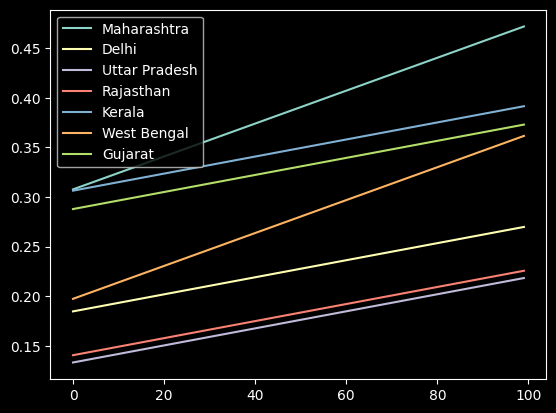

In [524]:
airport_zone_effect_change_process = AirPortEffectChangeProcess(
    "AirPortEffectChangeProcess",
    {"india": ind},
    "ALIVE",
    ["india", "india"],
    ["Pune International Airport", "Indira Gandhi International Airport"],
    [1, 1]
)

k = []
for i in range(100):
    k.append(airport_zone_effect_change_process.run(i))
    ind.sync()

data = {}
for i in k:
    for key, val in i.items():
        if key.split("_")[1] not in data:
            data[key.split("_")[1]] = []

        data[key.split("_")[1]].append(val)

for d in data:
    plt.plot(data[d], label=d)
plt.legend()
plt.show()

In [525]:
k

[{'ALIVE/AirPortEffectChangeProcess_Maharashtra_india': 0.3076500705181088,
  'ALIVE/AirPortEffectChangeProcess_Delhi_india': 0.18467037807043143,
  'ALIVE/AirPortEffectChangeProcess_Uttar Pradesh_india': 0.13317413478146867,
  'ALIVE/AirPortEffectChangeProcess_Rajasthan_india': 0.14051132124951463,
  'ALIVE/AirPortEffectChangeProcess_Kerala_india': 0.306347873657542,
  'ALIVE/AirPortEffectChangeProcess_West Bengal_india': 0.19733427578705703,
  'ALIVE/AirPortEffectChangeProcess_Gujarat_india': 0.2878113158158034},
 {'ALIVE/AirPortEffectChangeProcess_Maharashtra_india': 0.30930843604218905,
  'ALIVE/AirPortEffectChangeProcess_Delhi_india': 0.1855300660782305,
  'ALIVE/AirPortEffectChangeProcess_Uttar Pradesh_india': 0.13403382278926773,
  'ALIVE/AirPortEffectChangeProcess_Rajasthan_india': 0.1413710092573137,
  'ALIVE/AirPortEffectChangeProcess_Kerala_india': 0.3072075616653411,
  'ALIVE/AirPortEffectChangeProcess_West Bengal_india': 0.1989926413111373,
  'ALIVE/AirPortEffectChangeProc

In [526]:
class EpidemicEngintV1(EngineV1):
    MAX_STEPS: int = 100

In [527]:
SOMETHING = EpidemicEngintV1(
    "EpidemicEngintV1",
    ind,
    [birth_p, mask_implementaton_process, birth_p, mask_implementaton_process, birth_p, mask_implementaton_process],
    [ind, ind, ind, ind],
    30,
    120,
)

In [528]:
SOMETHING.status

'DORMANT'

In [529]:
SOMETHING.fire()


>> Starting Engine EpidemicEngintV1 EpidemicEngintV1.
New Loop Start time: 0.0
Check Value 2.0
in Else
Time: 1713358301.6546292 - 1713358301.6546292 = 0.0
Sleeping for 2.0 seconds.


<Thread(Thread-61 (simulation_loop), started 15364)>

Here
Schedule: [<__main__.BirthProcess object at 0x000001B714F87950>, <__main__.BirthProcess object at 0x000001B714F87950>, <__main__.BirthProcess object at 0x000001B714F87950>, <__main__.MaskImplementationProcess object at 0x000001B7784FE600>, <__main__.MaskImplementationProcess object at 0x000001B7784FE600>, <__main__.MaskImplementationProcess object at 0x000001B7784FE600>]
Unique Ranks: {0, 1}
Current Rank: 0
________________________________________
Process <__main__.BirthProcess object at 0x000001B714F87950> status: ALIVE
________________________________________
If <__main__.BirthProcess object at 0x000001B714F87950> in RUN method
________________________________________
Process <__main__.BirthProcess object at 0x000001B714F87950> status: ALIVE
________________________________________
________________________________________
Process <__main__.BirthProcess object at 0x000001B714F87950> status: ALIVE
________________________________________
If <__main__.BirthProcess object at 0x00000

In [530]:
1%120

1

In [531]:
SOMETHING.stop()

In [532]:
SOMETHING.info_history

{}